## Johnson-lindenstrauss lemma hands-on

Johnson-lindenstrauss lemma 를 3차원에서 만족하는 4가지 백터쌍을 찾습니다.

In [3]:
import torch
from torchtyping import TensorType

# 4가지 임의의 백터 쌍 생성.
vector_set: TensorType[4, 3] = (2 * torch.rand((4, 3)) - 1).requires_grad_(True)

In [4]:
import torch.nn.functional as F

def calculate_loss(vector_set: TensorType[4, 3]) -> TensorType[1]:
    # 모든 벡터 쌍 간의 내적 계산
    dot_product = torch.matmul(vector_set, vector_set.transpose(0,1))
    
    # 목표 행렬 생성: 대각선은 1, 나머지는 0
    target_matrix = torch.eye(4)
    
    # 직교성 손실 계산 - 서로 다른 벡터 간의 내적이 0이 되기를 원함
    orthogonality_loss = F.mse_loss(dot_product, target_matrix)
    
    # 크기 손실 계산 - 벡터들이 단위 길이를 가지기를 원함
    # 이는 dot_product의 대각 요소들이 1이 되기를 원하는 것과 동일
    size_loss = F.mse_loss(torch.diag(dot_product), torch.ones(4))

    # 전체 손실은 직교성 손실과 크기 손실의 합
    combined_loss = orthogonality_loss + size_loss

    return combined_loss

In [5]:
# 직교화 이전 손실
print(calculate_loss(vector_set).item())

0.5692050457000732


In [7]:
LR_INIT = 5e-7
ITERATIONS = 1000000

optim = torch.optim.AdamW([vector_set], lr=LR_INIT)

for i in range(ITERATIONS):
    optim.zero_grad()
    loss = calculate_loss(vector_set)
    loss.backward()
    optim.step()
    if i % 100000 == 0:
        print(f'Iteration {i:6d}, Loss: {loss.item():.6f}')

Iteration      0, Loss: 0.569205
Iteration 100000, Loss: 0.520904
Iteration 200000, Loss: 0.481378
Iteration 300000, Loss: 0.449280
Iteration 400000, Loss: 0.423829


KeyboardInterrupt: 

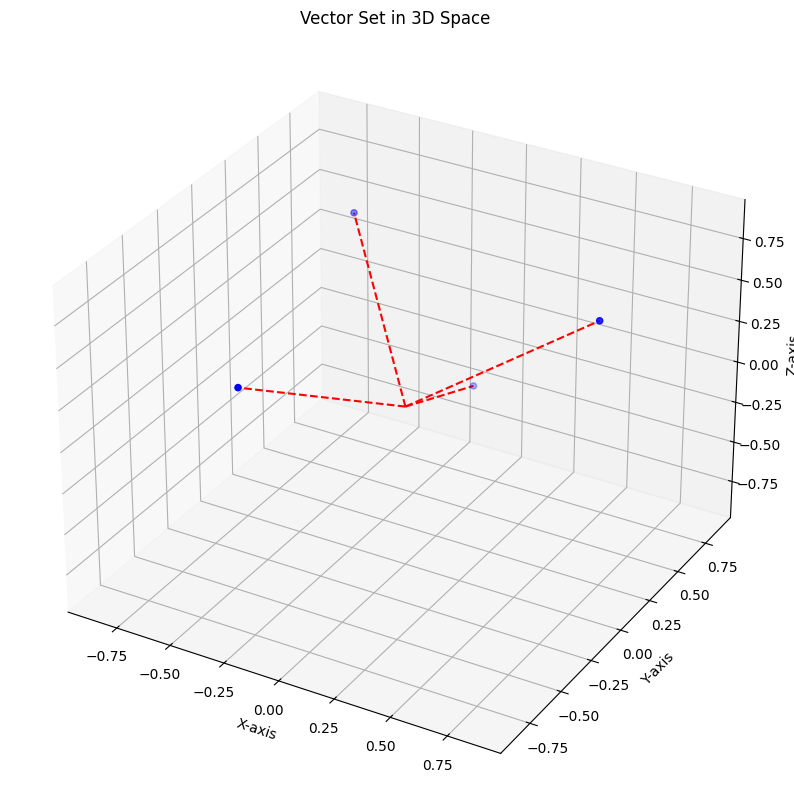

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 3D 그래프 생성
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 벡터 데이터 가져오기
vectors = vector_set.detach().numpy()

# 벡터를 점으로 표시
ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c='b', marker='o')

# 원점에서 각 점까지 선 그리기
for i in range(len(vectors)):
    ax.plot([0, vectors[i,0]], [0, vectors[i,1]], [0, vectors[i,2]], 'r--')

# 축 레이블 설정
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Vector Set in 3D Space')

# 그리드 추가
ax.grid(True)

# 일관된 축 범위 설정
limit = np.max(np.abs(vectors)) * 1.2
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit, limit)

plt.show()


In [10]:
dot_product = torch.round(torch.matmul(vector_set, vector_set.transpose(0,1)) * 100) / 100

print(dot_product)

tensor([[ 0.8200, -0.7400,  0.0300, -0.2000],
        [-0.7400,  0.9100,  0.3100, -0.1000],
        [ 0.0300,  0.3100,  1.0600,  0.1200],
        [-0.2000, -0.1000,  0.1200,  0.8900]], grad_fn=<DivBackward0>)


In [13]:
# 벡터들 사이의 각도 계산
angles = torch.zeros((len(vector_set), len(vector_set)))

for i in range(len(vector_set)):
    for j in range(len(vector_set)):
        # 벡터의 내적 구하기
        dot = torch.dot(vector_set[i], vector_set[j])
        # 벡터의 크기 구하기
        mag_i = torch.norm(vector_set[i])
        mag_j = torch.norm(vector_set[j])
        # 라디안 단위로 각도 계산
        cos_angle = dot / (mag_i * mag_j)
        # 부동소수점 오차 처리를 위한 클리핑
        cos_angle = torch.clamp(cos_angle, -1.0, 1.0)
        # 도(degree) 단위로 변환
        angle = torch.acos(cos_angle) * 180 / np.pi
        angles[i,j] = angle

# 깔끔한 출력을 위해 소수점 2자리까지 반올림
angles = torch.round(angles * 100) / 100

print("Angles between vectors (in degrees):")
print(angles)


Angles between vectors (in degrees):
tensor([[  0.0000, 149.5900,  87.9800, 103.6400],
        [149.5900,   0.0000,  71.6200,  96.1800],
        [ 87.9800,  71.6200,   0.0000,  83.0100],
        [103.6400,  96.1800,  83.0100,   0.0000]], grad_fn=<DivBackward0>)


In [ ]:
"""
임의의 차원에서 최대 직교하는 벡터쌍들의 각도 분포를 구합니다.
"""

DIMENSIONS = 1000
VECTOR_COUNT = 100 

vector_set = torch.randn((VECTOR_COUNT, DIMENSIONS)).requires_grad_(True)